In [25]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Split training set and testing set

def get_image_data(loc):
    return list(Image.open(loc).getdata())

In [27]:
path = '/Users/lee/Downloads/p1_data/'

train_set = []
train_label = []
test_set = []
test_label = []

for i in range(1, 41):
    for j in range(1, 10):
        train_set.append(get_image_data(path + '%s_%s.png'%(i, j)))
        train_label.append(i)
    
    test_set.append(get_image_data(path + '%s_10.png'%i))
    test_label.append(i)

# Switch list to array

train_set = np.array(train_set).astype(np.uint8).T #2576x360
train_label = np.array(train_label).T
test_set = np.array(test_set).astype(np.uint8).T    
test_label = np.array(test_label).T

print('Training set size: ', len(train_set))
print('testing set size: ', len(test_set))

Training set size:  2576
testing set size:  2576


Shape of mean face:  (2576,)


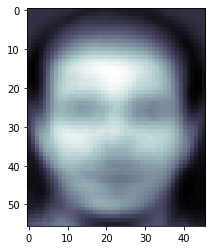

In [28]:
# Mean face

mean_face = np.mean(train_set, axis=1).astype(np.uint8)
print('Shape of mean face: ',mean_face.shape)
plt.imshow(mean_face.reshape(56,46),cmap=plt.cm.bone)

In [22]:
A = train_set - mean_face.reshape(-1,1) #2576x360
cov = np.matmul(A, A.T)/360
cov.shape

(2576, 2576)

In [23]:
#U, S, VT = np.linalg.svd(cov, full_matrices=0)
W, V = np.linalg.eig(cov)

In [21]:
V[:,0]

array([0.01988779, 0.0193881 , 0.0195304 , ..., 0.01923608, 0.01998559,
       0.02010397])

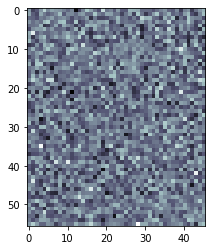

In [24]:
plt.imshow(V[:,0].reshape(56,46),cmap=plt.cm.bone)

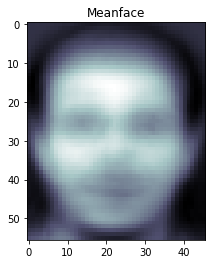

In [31]:
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics import mean_squared_error

pca = decomposition.PCA(n_components=360, whiten=True, svd_solver='full')
pca.fit(train_set.T)
plt.title('Meanface')
plt.imshow(pca.mean_.reshape(56,46),cmap=plt.cm.bone)

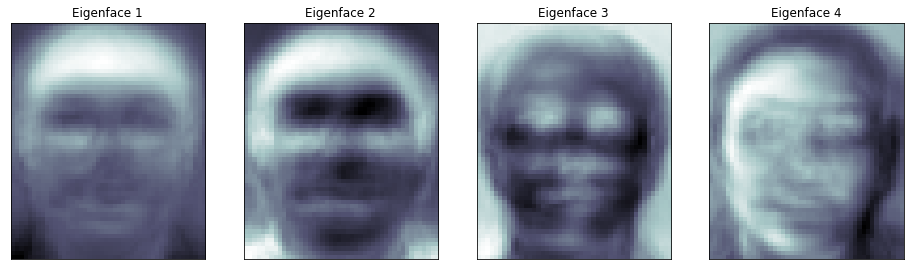

In [33]:
fig = plt.figure(figsize=(16, 6))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(56,46),cmap=plt.cm.bone)
    ax.set_title('Eigenface '+ str(i+1))

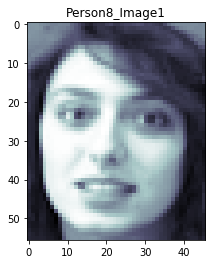

In [34]:
# person8image1

imagedata = np.array(get_image_data(path + '%s_%s.png'%(8, 1)))
plt.title('Person8_Image1')
plt.imshow(imagedata.reshape(56,46),cmap=plt.cm.bone)

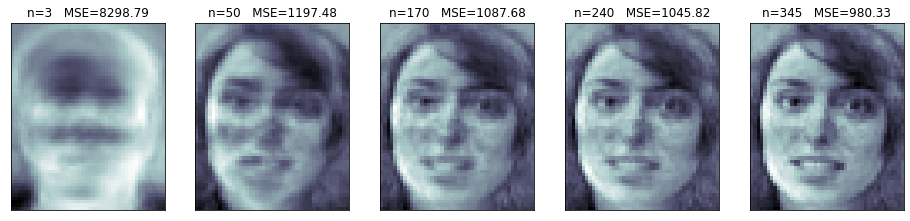

In [52]:
# Eigenface Reconstruction
# n = 3, 50, 170, 240, 345

n = [3, 50, 170, 240, 345]

weights = []
for i in range(len(pca.components_)):
    weights.append(np.dot(pca.components_[i].reshape(1,-1), (imagedata.reshape(-1,1) - pca.mean_))[0])
    
def reconstruction(n, weight):
    reimage = 0
    for i in range(n):
        reimage += weight[i]*pca.components_[i]
    return reimage
a = reconstruction(n[0], weights)
fig = plt.figure(figsize=(16, 6))
for i in range(len(n)):
    ax = fig.add_subplot(1, len(n), i + 1, xticks=[], yticks=[])
    ax.imshow(reconstruction(n[i], weights).reshape(56,46),cmap=plt.cm.bone)
    image_data = reconstruction(n[i], weights)
    norm_image = (image_data - np.min(image_data))/np.ptp(image_data)
    norm_image = norm_image * 255
    norm_image = norm_image.astype(np.uint8).reshape(-1,1)
    mse = mean_squared_error(imagedata, norm_image)
    ax.set_title('n='+str(n[i])+'   MSE='+'%.2f'%(mse))

In [638]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

dim = [3, 50, 170]
k_set = [1, 3, 5]

def pca_preprocessing(n, data): # d^2 x N
    p = decomposition.PCA(n_components=n, whiten=True, svd_solver='full').fit(data.T)
    return p

score = {}

for d in dim:
    pca = pca_preprocessing(d, train_set)
    for k in k_set:
        knn = KNeighborsClassifier(n_neighbors=k)
        auc = cross_val_score(knn, pca.transform(train_set.T), train_label, cv=3, scoring='accuracy')
        score['n='+str(d)+','+'k='+str(k)] = np.mean(auc)
        print('n='+str(d)+', '+'k='+str(k)+', '+'accuracy='+str(np.mean(auc)))

n=3, k=1, accuracy=0.6722222222222222
n=3, k=3, accuracy=0.6027777777777779
n=3, k=5, accuracy=0.5305555555555556
n=50, k=1, accuracy=0.888888888888889
n=50, k=3, accuracy=0.8416666666666668
n=50, k=5, accuracy=0.7999999999999999
n=170, k=1, accuracy=0.6083333333333333
n=170, k=3, accuracy=0.3527777777777778
n=170, k=5, accuracy=0.2611111111111111


In [637]:
# predict on testing set
knn = KNeighborsClassifier(n_neighbors=1)
pca = pca_preprocessing(50, train_set)
knn.fit(pca.transform(train_set.T), train_label)
knn.score(pca.transform(test_set.T), test_label.reshape(-1,1))

0.875